In [1]:
idx_functype = 0
padua_order = -3

# Functions: 0, 1, 2
# Orders: 1, 2, 3, 4, 5, 10 | -1, -2, -3, -4, -5, -6 | 
# (0,-6) didn't work
# (2, -1) didn't work
# (0, -2) didnt work

In [2]:
import sys
import os
import copy
import traceback

########################
# Find qslam modules
########################
sys.path.append('../qslam/')

from qslamdesignparams import GLOBALDICT
from riskanalysis import CreateQslamExpt as riskqslam
from riskanalysis import CreateNaiveExpt as risknaive
from riskanalysis import EngineeredTruth
from visualiserisk import *

sys.path.append('../qslam')
sys.path.append('../paduaq')
from pdinter_MM import pd_interpolant, calc_padua_cgl
from true_functions import true_function, generate_data_qubits_coords

sys.path.append('./')

In [3]:
########################
# Analysis parameters
########################

INFTYPE = 'expinf'
# SSIM
# Default Cone Ctwo too large for this application of ssim score. Decrease by factor of 100. 
Cone=0.000001
Ctwo=0.000001

data_qubit_num = 25
data_qubit_flag ='uniform'
TUNING_MULTIPLIER=5


########################
# Save/Load to path 
########################

PATHDICT['pdir'] = './data/' # load path

if INFTYPE == 'expinf':
    save_to_path = './data_expinf'

if INFTYPE == 'maxinf':
    save_to_path = './data_maxinf'
    

########################
# Set True Field
########################

if idx_functype ==0:
    true_function_type = 'cheb2fun'
    from tuningresults_nonpoly import SIMULATIONSDICT
    
if idx_functype ==1:
    true_function_type = 'lin'
    from tuningresults_linear import SIMULATIONSDICT

if idx_functype ==2:
    true_function_type = 'franke'
    from tuningresults_franke import SIMULATIONSDICT
    
if idx_functype ==3:
    true_function_type = 'gss'
    from tuningresults_gss import SIMULATIONSDICT

In [4]:
########################
# Generate Sensing Qubits
########################

# Sensor-qubits in Padua formation

if padua_order > 0:
    sensing_qubits = calc_padua_cgl(padua_order)[0]
    
# No data-qubits, basic analysis

if padua_order == -1: 
    sensing_qubits = generate_data_qubits_coords(data_qubit_num,
                                          flag=data_qubit_flag)

# Sensor-qubits in regular (non-Padua) formation

if padua_order == -2:
    FINEGRID = 81
    sensing_qubits = generate_data_qubits_coords(FINEGRID, flag=data_qubit_flag)

if padua_order == -3:
    COARSEGRID = 16
    sensing_qubits = generate_data_qubits_coords(COARSEGRID, flag=data_qubit_flag)
    
    # Re-position grid inside square region
    sensing_qubits = list(np.asarray(sensing_qubits) * 0.75)

if padua_order == -4:
    REG4 = 4
    sensing_qubits = generate_data_qubits_coords(REG4, flag=data_qubit_flag)
    sensing_qubits = list(np.asarray(sensing_qubits) * 0.75)

if padua_order == -5:
    REG9 = 9
    sensing_qubits = generate_data_qubits_coords(REG9, flag=data_qubit_flag)
    sensing_qubits = list(np.asarray(sensing_qubits) * 0.75)

if padua_order == -6:
    REG36 = 36
    sensing_qubits = generate_data_qubits_coords(REG36, flag=data_qubit_flag)

########################
# Generate Data Qubits
########################

if padua_order > 0:
    data_qubits = generate_data_qubits_coords(data_qubit_num, flag=data_qubit_flag)

    GLOBALDICT["DATA_QUBITS"] = np.arange(len(sensing_qubits),  len(sensing_qubits) + data_qubit_num, dtype='int')
    GLOBALDICT["INTERPOLATE_FLAG"] = padua_order
    prefix = true_function_type +'_padua_ord_'+str(padua_order)+'_'

if padua_order == -1: 
    GLOBALDICT["DATA_QUBITS"] = []
    GLOBALDICT["INTERPOLATE_FLAG"] = None
    prefix = true_function_type +'_no_padua_'
    padua_order = "no_padua"

if padua_order == -2:
    data_qubits = generate_data_qubits_coords(data_qubit_num, flag=data_qubit_flag)
    # remove duplicate sensors:
    sensing_qubits = list(set(sensing_qubits) - set(data_qubits))

    # update dictionary params:
    GLOBALDICT["DATA_QUBITS"] = np.arange(len(sensing_qubits), len(sensing_qubits) + data_qubit_num, dtype='int')
    GLOBALDICT["INTERPOLATE_FLAG"] = 'Rbf' # change this to 'Rbf'
    prefix = true_function_type +'_regfine_'
    
    # reset key for SIMULATIONSDICT
    padua_order = "regfine"

if padua_order <= -3:
    data_qubits = generate_data_qubits_coords(data_qubit_num, flag=data_qubit_flag)
    GLOBALDICT["DATA_QUBITS"] = np.arange(len(sensing_qubits),  len(sensing_qubits) + data_qubit_num, dtype='int')
    GLOBALDICT["INTERPOLATE_FLAG"] = 'Rbf' 
    
if padua_order == -3:
    prefix = true_function_type +'_regcoarse_'
    padua_order = "regcoarse"
    
if padua_order == -4:
    prefix = true_function_type +'_reg4_'
    padua_order = "reg4"
    
if padua_order == -5:
    prefix = true_function_type +'_reg9_'
    padua_order = "reg9"

if padua_order == -6:
    prefix = true_function_type +'_reg36_'
    padua_order = "reg36"
    


In [5]:
########################
# Set true map and qubit grid
########################
TRUTHKWARGS = {}
TRUTHKWARGS["truthtype"] = "UseFunction"
TRUTHKWARGS["true_function"] = true_function
TRUTHKWARGS["true_function_type"] = true_function_type

TRUTHKWARGS["all_qubit_locations"] = sensing_qubits 
if len(GLOBALDICT["DATA_QUBITS"]) > 0:
    TRUTHKWARGS["all_qubit_locations"] = sensing_qubits + data_qubits

num_of_nodes = len(TRUTHKWARGS["all_qubit_locations"])
true_map_ =  EngineeredTruth(num_of_nodes, TRUTHKWARGS).get_map()

GLOBALDICT["GRIDDICT"] = {}
for idx_posy in range(num_of_nodes):
    
    point = TRUTHKWARGS["all_qubit_locations"][idx_posy]

    if idx_posy < 10 :

        GLOBALDICT["GRIDDICT"]["QUBIT_0" + str(idx_posy)] = (point[0], point[1])

    if idx_posy >= 10 :

        GLOBALDICT["GRIDDICT"]["QUBIT_" + str(idx_posy)] =  (point[0], point[1])



In [6]:
########################
# Set Simulation Params
########################

GLOBALDICT["MODELDESIGN"]["MSMTS_PER_NODE"] = 1
GLOBALDICT["MODELDESIGN"]["MULTIPLER_R_MAX"] = 4.
repts = 50
particleconfigs = [ [3,2], [9,6], [15,10], [21,14], [30, 20]]

lambda_paris_2 = np.load('lambda_pairs_2.npz')
random_variances = np.load('random_variances.npz')

########################
# Set Loop Parameters
########################

Multiples = [1, 3, 5, 7, 9, 10, 15, 20, 50]

########################
# Extract Tuned Params
######## ###############

opt_method = "Uniform" # SIMULATIONSDICT[padua_order]["Opt_Beta_Expn"] 
idx_1 = SIMULATIONSDICT[padua_order][opt_method]["optimal"]["idx_1"]
idx_2 = SIMULATIONSDICT[padua_order][opt_method]["optimal"]["idx_2"]
idx_3 = SIMULATIONSDICT[padua_order][opt_method]["optimal"]["idx_3"]

GLOBALDICT["NOISEPARAMS"]["SIGMOID_APPROX_ERROR"]["SIGMA"] = random_variances['g2var'][idx_1]
GLOBALDICT["NOISEPARAMS"]["QUANTISATION_UNCERTY"]["SIGMA"] = random_variances['g1var'][idx_1]
GLOBALDICT["MODELDESIGN"]["LAMBDA_1"] = lambda_paris_2['lambda_1'][idx_2]
GLOBALDICT["MODELDESIGN"]["LAMBDA_2"] = lambda_paris_2['lambda_2'][idx_2]
GLOBALDICT["MODELDESIGN"]["P_ALPHA"] = particleconfigs[idx_3][0]
GLOBALDICT["MODELDESIGN"]["P_BETA"] = particleconfigs[idx_3][1]

fname_likelihood = 'optidx_'+str(idx_1)+'_'+str(idx_2)+'_'+str(idx_3)

max_msmtvar = len(Multiples)

In [7]:
########################
# Run Script
######## ###############

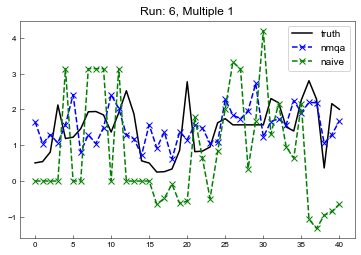

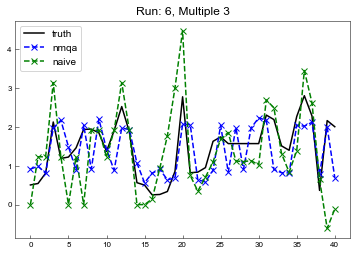

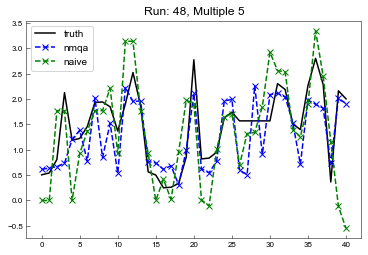

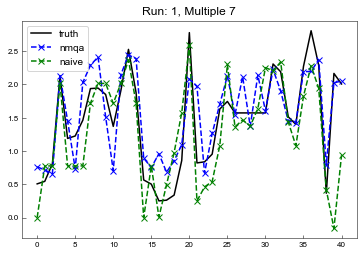

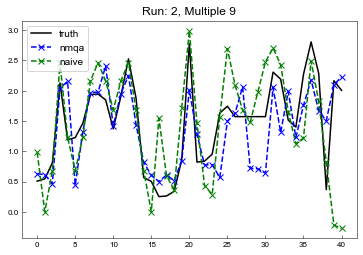

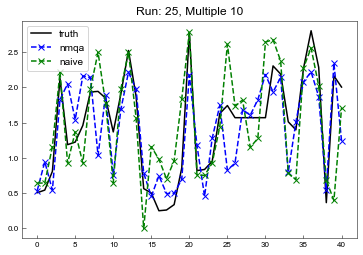

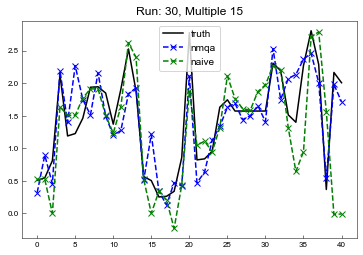

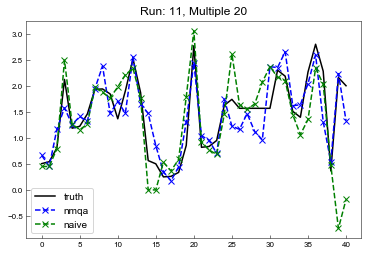

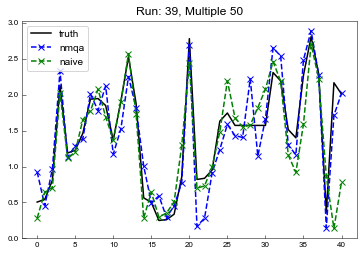

Made data file: ./data_expinf/RISK_cheb2fun_regcoarse_optidx_22_12_3.npz


In [8]:
if isinstance(padua_order, str):
    
    num_sensing_qubits = len(sensing_qubits)
    test_points = sensing_qubits
    macro_performance=[]

    for idx_msmt_var in Multiples:

        unique_ID = prefix + fname_likelihood + '_m_' + str(idx_msmt_var) 
        PATHDICT["fle"] = unique_ID

        perf_metrics = np.zeros((3, 4))


        qslamdata = np.load(path_to_file(PATHDICT, flag='q'))
        naivedata = np.load(path_to_file(PATHDICT, flag='n'))

        # Qslam - axis 0, index 0
        # Naive  - axis 0, index 1
        perf_metrics[:2, 0] = np.asarray([Metric.original_err_metric(data["macro_residuals"]) for data in [qslamdata, naivedata]])
        
        # Inf Norm - added for Padua application - here, we take inf norm over all trials
        perf_metrics[:2, 1] = np.asarray([Metric.infnorm(data["macro_residuals"], e_type=INFTYPE) for data in [qslamdata, naivedata]])
        
        # RMS error
        perf_metrics[:2, 2] = np.asarray([Metric.rms(data["macro_residuals"]) for data in [qslamdata, naivedata]])
        
        # SSIM error - Cone Ctwo  lowered for Padua application.
        perf_metrics[:2, 3] = np.asarray([Metric.ssim(data, Cone=Cone, Ctwo=Ctwo)[0] for data in [qslamdata, naivedata]]) # returning ssim (raw) or deviations

        macro_performance.append(perf_metrics)


        # ---------------------------------
        # Check Single Run Results
        # ---------------------------------   
        idx_run = np.random.randint(low=0, high=50)

        plt.figure()
        plt.title('Run: %s, Multiple %s' %(idx_run, idx_msmt_var))
        plt.plot(qslamdata["macro_true_fstate"][0, idx_run, :], 'k-', label='truth')
        plt.plot(qslamdata["macro_predictions"][0, idx_run, :], 'bx--', label='nmqa')
        plt.plot(naivedata['macro_predictions'][0, idx_run, :], 'gx--', label='naive')
        plt.legend(loc=0)
        plt.show()


    full_data_matrix = np.asarray(macro_performance)
    datafile = save_to_path +'/RISK_' + prefix + fname_likelihood +'.npz'
    np.savez(datafile, full_data_matrix=full_data_matrix)

    print "Made data file:", datafile

In [9]:
if isinstance(padua_order, int) and padua_order > 0:
    
    num_sensing_qubits = len(sensing_qubits)
    test_points = np.asarray(data_qubits)
    macro_performance=[]

    for idx_msmt_var in Multiples:

        unique_ID = prefix + fname_likelihood + '_m_' + str(idx_msmt_var) 
        PATHDICT["fle"] = unique_ID
        print PATHDICT["fle"], path_to_file(PATHDICT, flag='q')

        perf_metrics = np.zeros((3, 4))


        qslamdata = np.load(path_to_file(PATHDICT, flag='q'))
        naivedata = np.load(path_to_file(PATHDICT, flag='n'))

        # ---------------------------------
        # nmqa + padua
        # ---------------------------------

        qslam_interpolated_predictions = np.zeros_like(qslamdata["macro_predictions"])
        trials = qslamdata["macro_predictions"].shape[1]
        scores = np.zeros(trials)
        for idx_run in range(trials):

            truth = qslamdata["macro_true_fstate"][0, idx_run, :]

            # Calculate padau prediction using NMQA output
            sensing_data = qslamdata["macro_predictions"][0, idx_run, :num_sensing_qubits]
            interpolated_nmqa = np.diag(pd_interpolant(padua_order, sensing_data, [test_points[:,0], test_points[:,1]]))
            prediction = np.concatenate([sensing_data, interpolated_nmqa])

            qslam_interpolated_predictions[0, idx_run, :] = prediction 

            # Store ssim score
            scores[idx_run] = Metric.score_ssim(prediction, truth, Cone=Cone, Ctwo=Ctwo)

        # Calculate residuals
        interpolated_nmqa_residuals = qslam_interpolated_predictions - qslamdata["macro_true_fstate"]


        # Native qslam - axis 0, index 0
        # Naive using Padua interpolation - axis 0, index 1
        perf_metrics[:2, 0] = np.asarray([Metric.original_err_metric(data["macro_residuals"]) for data in [qslamdata, naivedata]])
        perf_metrics[:2, 1] = np.asarray([Metric.infnorm(data["macro_residuals"], e_type=INFTYPE) for data in [qslamdata, naivedata]])
        perf_metrics[:2, 2] = np.asarray([Metric.rms(data["macro_residuals"]) for data in [qslamdata, naivedata]])
        perf_metrics[:2, 3] = np.asarray([Metric.ssim(data, Cone=Cone, Ctwo=Ctwo)[0] for data in [qslamdata, naivedata]]) # returning ssim (raw) or deviations

        # Native qslam + padua interpolation on data qubits - axis 0, index 2
        perf_metrics[2, 0] = Metric.original_err_metric(interpolated_nmqa_residuals) 
        perf_metrics[2, 1] = Metric.infnorm(interpolated_nmqa_residuals)
        perf_metrics[2, 2] = Metric.rms(interpolated_nmqa_residuals)
        perf_metrics[2, 3] = np.mean(scores) # ssim

        macro_performance.append(perf_metrics)


        # ---------------------------------
        # Check Single Run Results
        # ---------------------------------   
        idx_run = np.random.randint(low=0, high=50)

        plt.figure()
        plt.title('Run: %s, Multiple %s' %(idx_run, idx_msmt_var))
        plt.plot(qslamdata["macro_true_fstate"][0, idx_run, :], 'k-',label='truth')

        plt.plot(qslamdata["macro_predictions"][0, idx_run, :], 'bx--', label='nmqa on padua')
        plt.plot(naivedata['macro_predictions'][0, idx_run, :], 'gx--', label='naive+padua')
        plt.plot(qslam_interpolated_predictions[0, idx_run, :], 'r--', label='nmqa with padua')
        plt.legend(loc=0)
        plt.show()


    full_data_matrix = np.asarray(macro_performance)
    datafile = save_to_path +'/RISK_' + prefix + fname_likelihood +'.npz'
    np.savez(datafile, full_data_matrix=full_data_matrix)

    print "Made data file:", datafile